# Code for materials science: Predicting properties of materials

## 1. Setup

In [1]:
pip install pymatgen pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


## 2. Python code

In [2]:
import pandas as pd
from pymatgen.core import Composition
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Material BandGap dataset

In [26]:
data = {
    'formula': [
        'Fe', 'Al', 'Si', 'Fe2Al', 'Fe3Si', 'AlFe', 'Si2Fe', 'FeSi', 'FeAl', 'Al2Si',
        'Fe4Al', 'Al3Si', 'FeSi2', 'Si3Al', 'Al2Fe', 'FeAl3', 'SiAl2', 'Fe3Al', 'Fe2Si', 'SiFe3',
        'Fe3Al2', 'Al4Si', 'Fe2Si3', 'Fe5Si2', 'AlFe3', 'SiAl3', 'FeSi3', 'Al5Si3', 'Si2Al2', 'Fe6Al2',
        'Fe2Al3', 'FeAl2Si', 'Fe4Al3', 'AlFe2Si', 'SiFe4', 'Al3Fe', 'Fe3Si2', 'Al2Fe3', 'FeSiAl', 'Fe2AlSi'
    ],
    'bandgap': [
        0.0, 0.0, 1.1, 0.0, 0.0, 0.0, 0.7, 0.6, 0.1, 1.3,
        0.0, 1.2, 0.9, 1.4, 0.1, 1.5, 1.2, 0.0, 0.2, 0.3,
        0.1, 1.5, 0.8, 0.2, 0.0, 1.6, 1.3, 1.1, 1.0, 0.0,
        0.1, 0.9, 0.0, 0.8, 0.3, 0.1, 0.5, 0.2, 0.6, 0.4
    ]
}
df = pd.DataFrame(data)


In [27]:
print(df)

    formula  bandgap
0        Fe      0.0
1        Al      0.0
2        Si      1.1
3     Fe2Al      0.0
4     Fe3Si      0.0
5      AlFe      0.0
6     Si2Fe      0.7
7      FeSi      0.6
8      FeAl      0.1
9     Al2Si      1.3
10    Fe4Al      0.0
11    Al3Si      1.2
12    FeSi2      0.9
13    Si3Al      1.4
14    Al2Fe      0.1
15    FeAl3      1.5
16    SiAl2      1.2
17    Fe3Al      0.0
18    Fe2Si      0.2
19    SiFe3      0.3
20   Fe3Al2      0.1
21    Al4Si      1.5
22   Fe2Si3      0.8
23   Fe5Si2      0.2
24    AlFe3      0.0
25    SiAl3      1.6
26    FeSi3      1.3
27   Al5Si3      1.1
28   Si2Al2      1.0
29   Fe6Al2      0.0
30   Fe2Al3      0.1
31  FeAl2Si      0.9
32   Fe4Al3      0.0
33  AlFe2Si      0.8
34    SiFe4      0.3
35    Al3Fe      0.1
36   Fe3Si2      0.5
37   Al2Fe3      0.2
38   FeSiAl      0.6
39  Fe2AlSi      0.4


# 2. Feature engineering (representing material composition)
# We'll use a simple approach: fractional composition of elements

In [28]:
def featurize_composition(formula):
    comp = Composition(formula)
    element_counts = comp.get_el_amt_dict()
    total = sum(element_counts.values())
    return pd.Series({
        'Fe_fraction': element_counts.get('Fe', 0) / total,
        'Al_fraction': element_counts.get('Al', 0) / total,
        'Si_fraction': element_counts.get('Si', 0) / total
    })

df_features = df['formula'].apply(featurize_composition)
df_combined = pd.concat([df_features, df['bandgap']], axis=1)

# 3. Data splitting

In [29]:
X = df_combined[['Fe_fraction', 'Al_fraction', 'Si_fraction']]
y = df_combined['bandgap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model selection and training (Random Forest Regressor)

In [30]:
model = RandomForestRegressor(n_estimators=100, random_state=42) # Using 100 decision trees
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 4.5 Cross-validation (5-fold)

In [31]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_mae = -np.mean(cv_scores)
print(f"Cross-validated MAE (5-fold): {mean_cv_mae:.3f}")

Cross-validated MAE (5-fold): 0.231


# 5. Model evaluation

In [32]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [33]:
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2): {r2:.3f}")


Mean Absolute Error (MAE): 0.338
R-squared (R2): 0.058


# 6. Visualization with Seaborn and Matplot

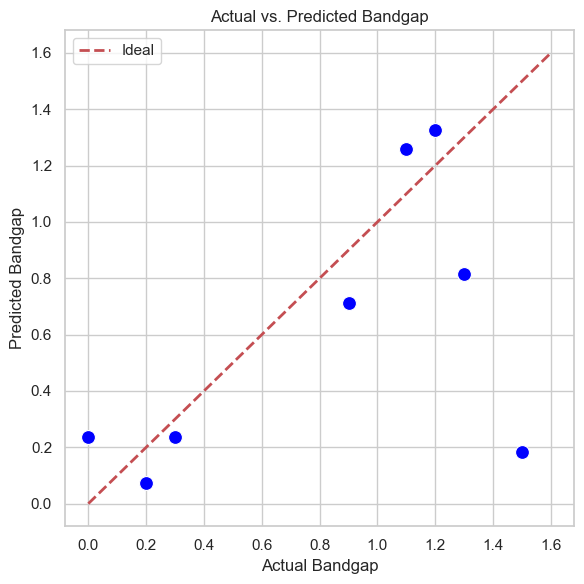

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, s=100, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Bandgap")
plt.ylabel("Predicted Bandgap")
plt.title("Actual vs. Predicted Bandgap")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Prediction for a new material (e.g., FeAlSi)

In [36]:
new_material_formula = "FeAlSi"
new_material_features = featurize_composition(new_material_formula).to_frame().T 
predicted_bandgap = model.predict(new_material_features)[0]
print(f"Predicted bandgap for {new_material_formula}: {predicted_bandgap:.3f}")

Predicted bandgap for FeAlSi: 0.653
